In [1]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
from astropy.table import Table, Column
from scipy import optimize
import json

In [2]:
# Set the database and query
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')

# Set the output directory
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

In [30]:
# Set desired filters, range of location and mangitudes of peak, and sample light curve here
filterNames = ['g', 'r', 'i', 'z']
colors = {'u':'cyan','g':'g','r':'blue','i':'r','z':'m', 'y':'k'}
#Consider red filter for the two below
location_of_peak = np.arange(0,50, 10)
height_of_peak = np.arange(16, 18, 0.5)
#location_of_peak = [10]
#height_of_peak = [17]
jsonLC = 'iPTF13bvn.json'

In [37]:
# The pass metric just passes data straight through.
#choose database and restrictions (such as list of ra and dec)
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
slicer = slicers.UserPointsSlicer(np.random.uniform(0,360,5), np.random.uniform(-60,-30,5))
#no restrictions currently
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                        outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [21]:
def createdict_for_mjd_filter_depth(bundle):
    
    """This function returns a list of tables of exposure day, filter, and five sigma depth for each ra and dec chosen"""
    
    listofDict = []
    for coord in range(len(bundle.metricValues)):
        bdict = {key: bundle.metricValues[coord][key] for key in ['fieldRA', 'fieldDec', 'expMJD', 'filter', 'fiveSigmaDepth']}
        t = Table(bdict)
        t.rename_column('expMJD', 'day')
        listofDict.append(t)
    return listofDict

In [22]:
class ReadCurve():
    #Read in asciifile and interpolate data for each filter
    
    def __init__(self, jsonfile):
        self.read_lightcurve(jsonfile)

    def read_lightcurve(self, jsonfile):
        # Open and load json file with sne values
        sne_data = open(jsonfile)
        sne = json.load(sne_data)
        # Set up dictionary for json data
        data = {'day': [], 'filter': [], 'mag': [], 'magerror': [], 'upperlimit': []}
        # Use for loop to call to values within the json file
        for entry in sne['iPTF13bvn']['photometry']:
            # Ignore instances in which 'band' and 'magnitude' have no data
            if 'band' in entry and 'magnitude' in entry:
                data['day'].append(float(entry['time']))
                data['filter'].append(entry['band'])
                data['mag'].append(float(entry['magnitude']))
                # Ignore instances in which 'upperlimit' has no value (i.e. is 'false')
                if 'upperlimit' in entry:
                    data['upperlimit'].append(entry['upperlimit'])
                else:
                    data['upperlimit'].append(False)
                # Ignore instances in which 'e_magnitude' has no value (i.e. upperlimit IS the error)
                if 'e_magnitude' in entry:
                    data['magerror'].append(float(entry['e_magnitude']))
                else:
                    data['magerror'].append(99)
        # Table the now-full dictionary of sne data
        sne_table = Table(data)
        # Update the table to modify the data for magnitude errors no more than 0.3, no upperlimit values,
        # mjd in terms of obvservation day number, and filters in only g, r, i, and z.
        sne_table = sne_table[sne_table['magerror'] < 0.3]
        sne_table = sne_table[sne_table['upperlimit'] == False]
        sne_table = sne_table[sne_table['filter'] != 'V']
        sne_table = sne_table[sne_table['filter'] != 'R']
        sne_table = sne_table[sne_table['filter'] != 'W1']
        sne_table = sne_table[sne_table['filter'] != 'B']
        sne_table = sne_table[sne_table['filter'] != 'U']
        sne_table = sne_table[sne_table['filter'] != 'I']
        sne_table = sne_table[sne_table['filter'] != 'W2']
        sne_table['day'] = sne_table['day'] - sne_table['day'].min()
        sne_table = sne_table['day', 'filter', 'mag', 'magerror']
        return sne_table

In [23]:
def interpolate_light_curve(adjusted_lc_table, survey):
    
    #for each filter interpolate the read in light curve to the days of the survey in all filters
    
    lc = {}
    for f in filterNames:
        fMatch = np.where(adjusted_lc_table['filter'] == f)
        lc[f] = np.interp(survey['day'], adjusted_lc_table['day'][fMatch], adjusted_lc_table['mag'][fMatch])
    lightcurve = Table(lc)
    lightcurve['day'] = survey['day']
    lightcurve = lightcurve['day', 'g', 'r', 'i', 'z']
    return lightcurve

In [24]:
def resample_light_curve(lightcurve, opsim):
    
    """add to the opsim table a magnitude column where the magnitude is taken from the index of the interpolated
        light curve where both the filter and day matched the opsim"""
    opsim1 = opsim.copy()
    opsim1['magnitude'] = 0.
    for row in range(len(opsim1)):
        filterName = opsim1['filter'][row]
        opsim1['magnitude'][row] = lightcurve[filterName][row]
    opsim1 = opsim1['day','filter','magnitude','fiveSigmaDepth']
    opsim1.sort('day')
    return opsim1

In [25]:
def peak_brightness(lc_table):
    
    #This function returns a table of peak magnitude and the day it occurs for each filter from the read in lightcurve
    
    peak_brightness = {}
    for f in filterNames:
        fMatch = np.where(lc_table['filter'] == f)
        maxmag = np.amin(lc_table['mag'][fMatch])
        location = np.argmin(lc_table['mag'][fMatch])
        maxday = lc_table['day'][fMatch][location]
        peak_brightness[f] = [maxday, maxmag]
    
    peak = Table(peak_brightness)
    peak[' '] = ['day', 'magnitude']
    orderedPeak = peak[' ','g','r','i','z']
    return orderedPeak

In [26]:
def adjust_peak(lc_table, peaktable, peakday, peakmag):
    
    """This function finds the necessary adjustment needed to make the peak of the red filter occur at the right place
        and adjusts all filters by that same ammount"""
    adjusted_lc_table = lc_table.copy()
    
    peak_day_difference = peaktable['r'][0] - peakday
    adjusted_lc_table['day'] = adjusted_lc_table['day'] - peak_day_difference
    
    peak_mag_difference = peaktable['r'][1] - peakmag
    adjusted_lc_table['mag'] = adjusted_lc_table['mag'] - peak_mag_difference
    
    return adjusted_lc_table

In [27]:
def calculate_error(survey):
    
    #Calculate the error of the magnitude at each point from the magnitude and fiveSigmaDepth stored in survey
    
    snr = 5.*10.**(-0.4*(survey['magnitude'] - survey['fiveSigmaDepth']))
    lc_err = 2.5/(np.log(10)*snr)
    survey['error'] = lc_err
    
    return survey

In [28]:
def plot_light_curve(opsim_fmatch2, f, ra, dec, day, mag):
    
    #Plot the resampled light curve (day vs. magnitude) with error for each filter
    fig, ax = plt.subplots(1,1)
    ax.errorbar(opsim_fmatch2['day'], opsim_fmatch2['magnitude'], opsim_fmatch2['error'], fmt = 'o', color=colors[f])
    ax.set_ylim(20,15)
    ax.set_xlim(0,365)
    ax.set_xlabel('Days')
    ax.set_ylabel('Magnitude')
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax.legend(handles, [f for f in filterNames], fontsize='smaller', numpoints=1)
    ax.set_title('Resampled Light Curve for ra = %r and dec = %r and peakday = %d and peakmag = %d ' %(ra, dec, day, mag))

In [13]:
def interpolate_original(lc_table, times):
    lc_original = {}
    #for each filter plot the corresponding light curve created in Make_LightCurve
    for f in filterNames:
        fMatch = np.where(lc_table['filter'] == f)
        lc_original[f] = np.interp(times, lc_table['day'][fMatch], lc_table['mag'][fMatch])
    lightcurve2 = Table(lc_original)
    lightcurve2['day'] = times
    lightcurve2 = lightcurve2['day', 'g', 'r', 'i', 'z']
    return lightcurve2

In [14]:
def change_lightcurve_to_table(lightcurve2):
    
    opsim2 = Table()
    opsim2.add_column(Column(name='day'))
    opsim2.add_column(Column(name='mangitude'))
    opsim2.add_column(Column(name='filter'))
    opsim2 = Table(names=('day', 'magnitude', 'filter'), dtype=('float', 'float', 'string'))
    for day in lightcurve2['day']:
        for f in filterNames:
            row = np.where(lightcurve2['day'] == day)
            opsim2.add_row([day, lightcurve2[f][row][0], f])            
    return opsim2

In [15]:
def func2(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

In [16]:
def create_curve2(2, 3, f, adjusted_lc_table, ra, dec, peakday, peakmag):
    curve = np.copy(2)
    curve = Table(curve)
    fMatch = np.where(adjusted_lc_table['filter'] == f)
    curve = curve[curve['day'] <= adjusted_lc_table['day'][fMatch].max()]

    survey2 = np.copy(3)
    survey2 = Table(survey2)
    survey2 = survey2[survey2['day'] <= adjusted_lc_table['day'][fMatch].max()]

    xdata = np.arange(0, curve['day'].max(), 1)
    popt, pcov = optimize.curve_fit(func2, curve['day'], curve['magnitude'])
    plt.plot(xdata, func2(xdata, *popt), 'orange' , label='fit')
    plt.errorbar(curve['day'], curve['magnitude'], 
               yerr = curve['error'], fmt = 'o', color=colors[f], label=f)
    plt.plot(survey2['day'], survey2['magnitude'], color=colors[f], label=f)
    plt.xlabel('day')
    plt.ylabel('magnitude')
    plt.ylim(20,15)
    plt.legend(numpoints = 1)
    plt.title('Lightcurve at ra = %r and dec = %r, peakday = %r and peakmag = %r' %(ra, dec, peakday, peakmag))
    plt.show()

In [17]:
def resampled_peak_magnitude(opsim_fmatch2, f, adjusted_lc_table, ra, dec):
  
    fMatch = np.where(adjusted_lc_table['filter'] == f)

    survey = np.copy(opsim_fmatch2)
    survey = Table(survey)
    survey = survey[survey['day'] <= adjusted_lc_table['day'][fMatch].max()]

    xdata = np.arange(0, survey['day'].max(), 2)
    popt, pcov = optimize.curve_fit(func2, survey['day'], survey['magnitude'])

    peak_magnitude_difference = abs(adjusted_lc_table['mag'].min() - func2(xdata, *popt).min())
    
    print('ra = %r, dec = %r, filter = %s, peak magnitude difference = %r' %(ra, dec, f, peak_magnitude_difference))

In [18]:
def resampled_peak_day(opsim_fmatch2, f, adjusted_lc_table, ra, dec):

    fMatch = np.where(adjusted_lc_table['filter'] == f)

    survey = np.copy(opsim_fmatch2)
    survey = Table(survey)
    survey = survey[survey['day'] <= adjusted_lc_table['day'][fMatch].max()]

    xdata = np.arange(0, survey['day'].max() + 10, 1)
    popt, pcov = optimize.curve_fit(func2, survey['day'], survey['magnitude'])

    actual_peak_day = adjusted_lc_table['day'][adjusted_lc_table['mag'].argmin()]
    fitted_peak_day = func2(xdata, *popt).argmin()
    peak_day_difference = abs(actual_peak_day - fitted_peak_day)
    print('ra = %r, dec = %r, filter = %s, peak magnitude difference = %r' %(ra, dec, f, peak_day_difference))

      day       filter  magnitude   fiveSigmaDepth       error      
--------------- ------ ------------ -------------- -----------------
            0.0      g    16.506268      24.284573 0.000168047600478
0.0215620000017      g 16.507712654      24.256147 0.000172735092638
0.0283679999993      g 16.508168656      24.143668 0.000191670192063
0.0535569999993      g 16.509856319      24.301815 0.000165947549327
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r 16.0456458433      24.141548 0.000125427698377
 2.044932      r 16.0465243489      24.032428 0.000138801083156
 2.047245      r 16.0466028191      23.978719 0.000145850473458
  2.07218      r 16.0474487561      24.124561 0.000127617260638
15.969716      r 17.1164457354      24.078713 0.000356325915642
15.979383      r 17.1170688742      23.998156 0.000383989602864
16.904195      r 17.1766826307      24.226121  0.00032883570558
16.927367 

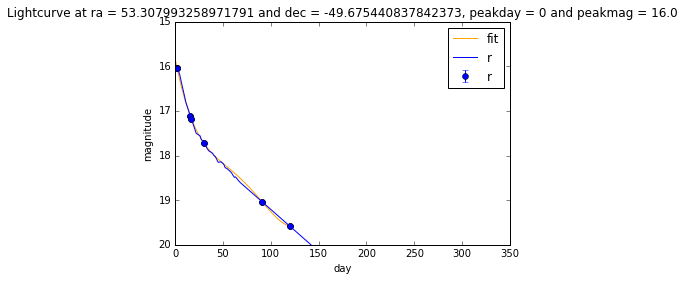

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 1.037857      i 16.0964964915      23.784268  0.00018266095008
 1.057236      i 16.0962243691      23.921264 0.000160967597938
14.091929      i 16.8054306273      23.528963  0.00044395746874
19.896267      i  17.152209217      23.330298 0.000733700478701
 19.91221      i 17.1531617272      23.537614 0.000606699177961


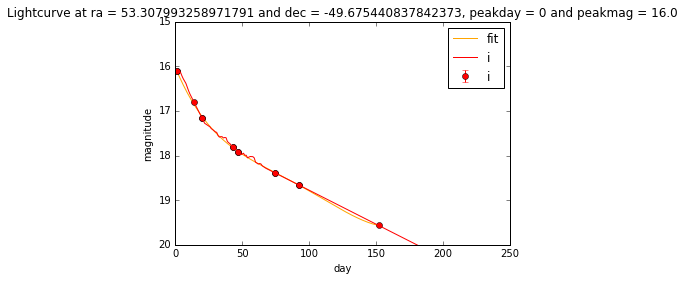

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 4.005337      z 16.0251438665      23.106854 0.000319205423912
 4.017258      z  16.025793561      23.222483 0.000287129979562
28.093268      z 16.8325444929      21.744084   0.0023558005173
28.102726      z 16.8326940307      21.764722  0.00231176203867
      day       filter  magnitude   fiveSigmaDepth       error      
--------------- ------ ------------ -------------- -----------------
            0.0      g    17.006268      24.284573 0.000266337498008
0.0215620000017      g 17.007712654      24.256147 0.000273766672421
0.0283679999993      g 17.008168656      24.143668 0.000303776782598
0.0535569999993      g 17.009856319      24.301815 0.000263009141234
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r 16.5456458433      24.141548 0.000198789505304
 2.044932 

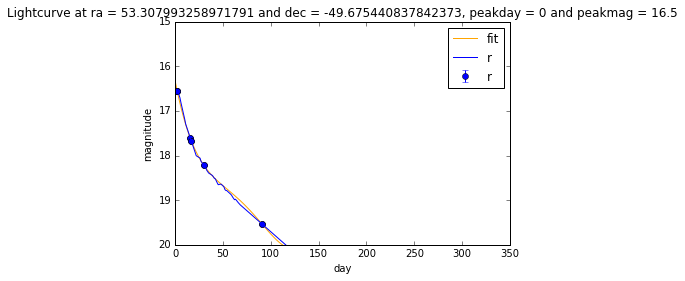

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 1.037857      i 16.5964964915      23.784268  0.00028949809631
 1.057236      i 16.5962243691      23.921264 0.000255116450178
14.091929      i 17.3054306273      23.528963 0.000703625169948
19.896267      i  17.652209217      23.330298    0.001162836894
 19.91221      i 17.6531617272      23.537614 0.000961553397022


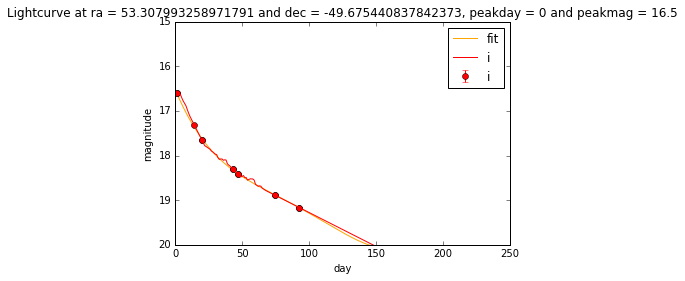

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 4.005337      z 16.5251438665      23.106854 0.000505906503354
 4.017258      z  16.525793561      23.222483  0.00045507034996
28.093268      z 17.3325444929      21.744084  0.00373369220266
28.102726      z 17.3326940307      21.764722  0.00366389591767
      day       filter  magnitude   fiveSigmaDepth       error      
--------------- ------ ------------ -------------- -----------------
            0.0      g    17.506268      24.284573 0.000422116487489
0.0215620000017      g 17.507712654      24.256147 0.000433890935443
0.0283679999993      g 17.508168656      24.143668 0.000481453754768
0.0535569999993      g 17.509856319      24.301815 0.000416841397497
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r 17.0456458433      24.141548 0.000315060133689
 2.044932 

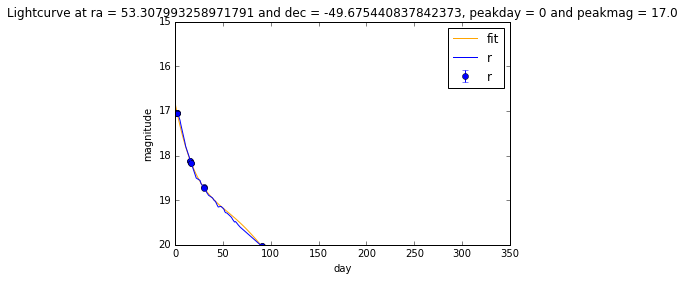

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 1.037857      i 17.0964964915      23.784268 0.000458823562072
 1.057236      i 17.0962243691      23.921264 0.000404332325172
14.091929      i 17.8054306273      23.528963   0.0011151707419
19.896267      i  18.152209217      23.330298  0.00184297227724
 19.91221      i 18.1531617272      23.537614  0.00152395943313


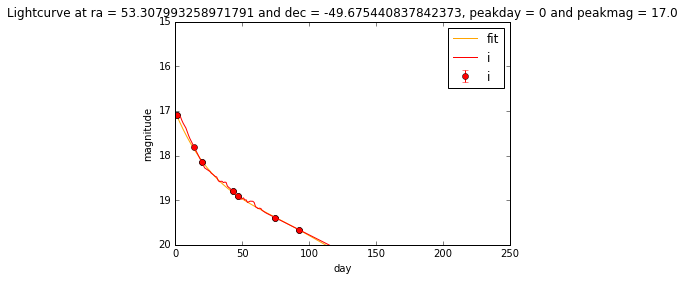

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 4.005337      z 17.0251438665      23.106854 0.000801807773188
 4.017258      z  17.025793561      23.222483 0.000721237899742
28.093268      z 17.8325444929      21.744084  0.00591750335474
28.102726      z 17.8326940307      21.764722   0.0058068836978
      day       filter  magnitude   fiveSigmaDepth       error      
--------------- ------ ------------ -------------- -----------------
            0.0      g    18.006268      24.284573 0.000669009547448
0.0215620000017      g 18.007712654      24.256147 0.000687670789855
0.0283679999993      g 18.008168656      24.143668 0.000763052778416
0.0535569999993      g 18.009856319      24.301815 0.000660649093228
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r 17.5456458433      24.141548   0.0004993366611
 2.044932 

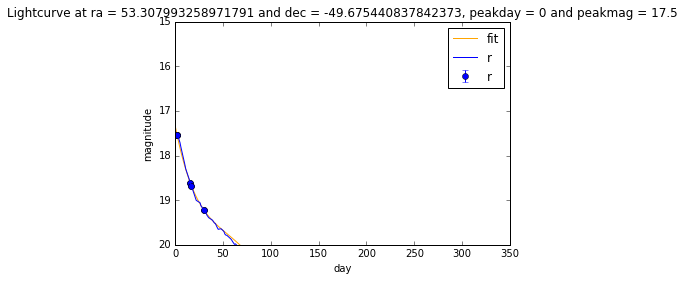

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 1.037857      i 17.5964964915      23.784268 0.000727186340069
 1.057236      i 17.5962243691      23.921264 0.000640823549657
14.091929      i 18.3054306273      23.528963  0.00176742651726
19.896267      i  18.652209217      23.330298   0.0029209142161
 19.91221      i 18.6531617272      23.537614  0.00241531293115


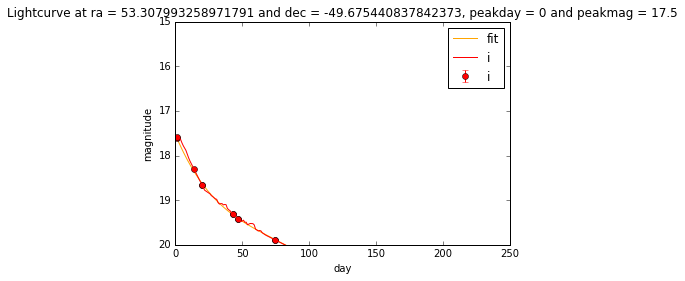

   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 4.005337      z 17.5251438665      23.106854 0.00127077968139
 4.017258      z  17.525793561      23.222483 0.00114308503745
28.093268      z 18.3325444929      21.744084  0.0093786107833
28.102726      z 18.3326940307      21.764722 0.00920329044206
      day       filter   magnitude   fiveSigmaDepth       error      
--------------- ------ ------------- -------------- -----------------
            0.0      g 16.8616969697      24.284573 0.000233133081173
0.0215620000017      g      16.85843      24.256147 0.000238598393735
0.0283679999993      g 16.8573987879      24.143668  0.00026439097767
0.0535569999993      g 16.8549967628      24.301815 0.000228048395375
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r 16.3755674424      24.141548  0.00016996601518
 2.044932 

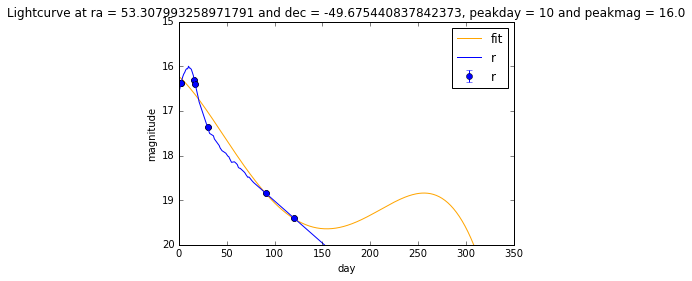

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 1.037857      i 16.6146618214      23.784268 0.000294382401746
 1.057236      i 16.6127832449      23.921264 0.000259037126375
14.091929      i  16.142913002      23.528963 0.000241176126893
19.896267      i 16.5290006239      23.330298 0.000413271413101
 19.91221      i 16.5315896581      23.537614 0.000342250884266


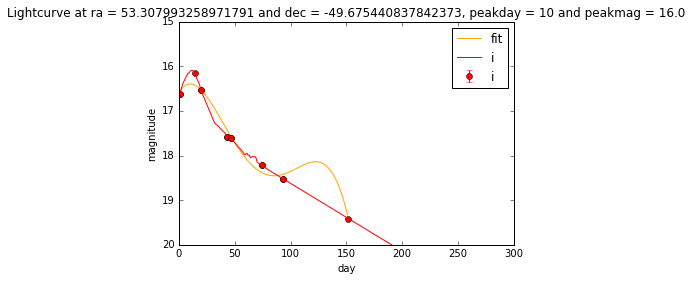

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 4.005337      z 16.2712679239      23.106854  0.00040042380224
 4.017258      z 16.2707795793      23.222483 0.000359809766423
28.093268      z 16.5798967444      21.744084  0.00186672100089
28.102726      z 16.5802759242      21.764722  0.00183221268387
      day       filter   magnitude   fiveSigmaDepth       error      
--------------- ------ ------------- -------------- -----------------
            0.0      g 17.3616969697      24.284573 0.000369491033289
0.0215620000017      g      17.35843      24.256147 0.000378152969963
0.0283679999993      g 17.3573987879      24.143668 0.000419031460658
0.0535569999993      g 17.3549967628      24.301815 0.000361432349381
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r 16.8755674424      24.141548 0.000269377980409
 2.0

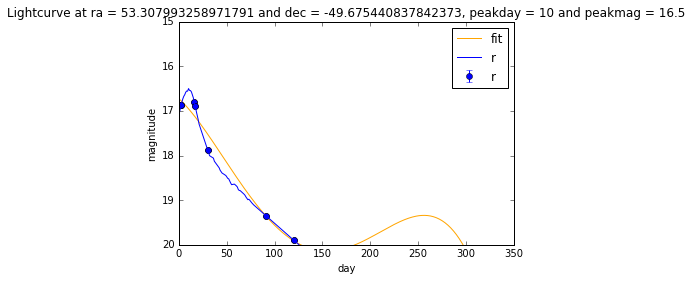

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 1.037857      i 17.1146618214      23.784268 0.000466564664507
 1.057236      i 17.1127832449      23.921264 0.000410546178186
14.091929      i  16.642913002      23.528963 0.000382238401697
19.896267      i 17.0290006239      23.330298 0.000654991049263
 19.91221      i 17.0315896581      23.537614 0.000542431096587


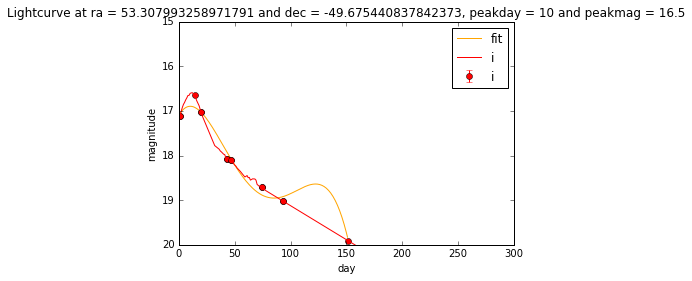

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 4.005337      z 16.7712679239      23.106854  0.00063462895827
 4.017258      z 16.7707795793      23.222483 0.000570260049385
28.093268      z 17.0798967444      21.744084  0.00295855340654
28.102726      z 17.0802759242      21.764722  0.00290386140981
      day       filter   magnitude   fiveSigmaDepth       error      
--------------- ------ ------------- -------------- -----------------
            0.0      g 17.8616969697      24.284573 0.000585603823336
0.0215620000017      g      17.85843      24.256147 0.000599332067803
0.0283679999993      g 17.8573987879      24.143668 0.000664120109424
0.0535569999993      g 17.8549967628      24.301815  0.00057283167007
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r 17.3755674424      24.141548 0.000426935327349
 2.0

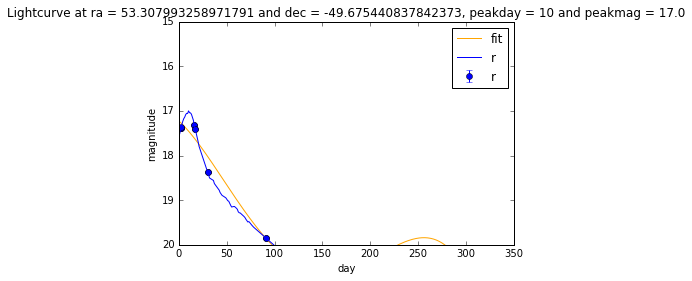

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 1.037857      i 17.6146618214      23.784268  0.00073945516062
 1.057236      i 17.6127832449      23.921264 0.000650671842998
14.091929      i  17.142913002      23.528963 0.000605807040747
19.896267      i 17.5290006239      23.330298   0.0010380908551
 19.91221      i 17.5315896581      23.537614  0.00085969535236


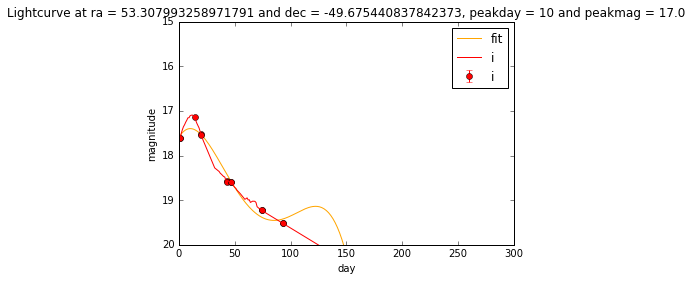

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 4.005337      z 17.2712679239      23.106854   0.0010058191157
 4.017258      z 17.2707795793      23.222483 0.000903801270202
28.093268      z 17.5798967444      21.744084  0.00468899115356
28.102726      z 17.5802759242      21.764722  0.00460231018026
      day       filter   magnitude   fiveSigmaDepth       error      
--------------- ------ ------------- -------------- -----------------
            0.0      g 18.3616969697      24.284573 0.000928119513084
0.0215620000017      g      18.35843      24.256147 0.000949877314284
0.0283679999993      g 18.3573987879      24.143668   0.0010525594404
0.0535569999993      g 18.3549967628      24.301815  0.00090787701432
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r 17.8755674424      24.141548 0.000676646893937
 2.0

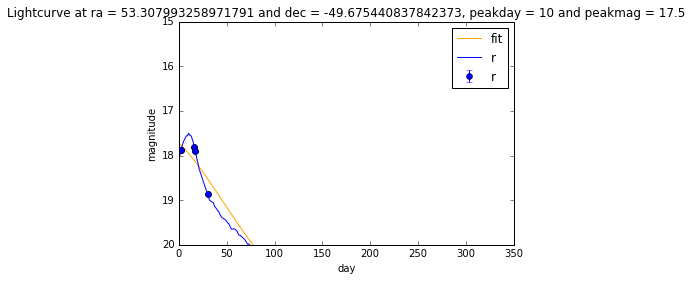

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 1.037857      i 18.1146618214      23.784268   0.0011719574502
 1.057236      i 18.1127832449      23.921264  0.00103124537449
14.091929      i  17.642913002      23.528963 0.000960139454826
19.896267      i 18.0290006239      23.330298   0.0016452631294
 19.91221      i 18.0315896581      23.537614  0.00136252531155


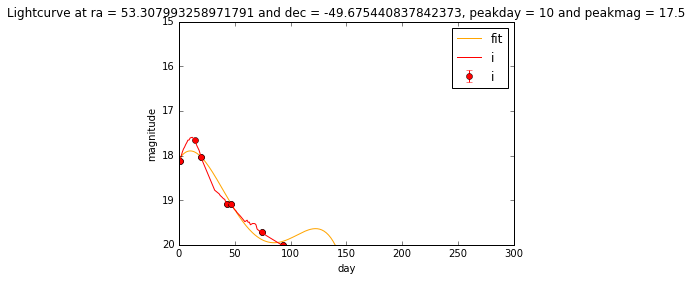

   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 4.005337      z 17.7712679239      23.106854 0.00159411586932
 4.017258      z 17.7707795793      23.222483 0.00143242848048
28.093268      z 18.0798967444      21.744084 0.00743155015879
28.102726      z 18.0802759242      21.764722 0.00729417007429
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r     19.511232      24.141548  0.00305230491239
 2.044932      r  19.514011039      24.032428   0.0033836663408
 2.047245      r 19.5115566754      23.978719  0.00354723030275
  2.07218      r 19.4850977239      24.124561  0.00302669741056
15.969716      r 16.1393337085      24.078713 0.000144878052378
15.979383      r 16.1389881421      23.998156 0.000155986557077
16.904195      r 16.089034

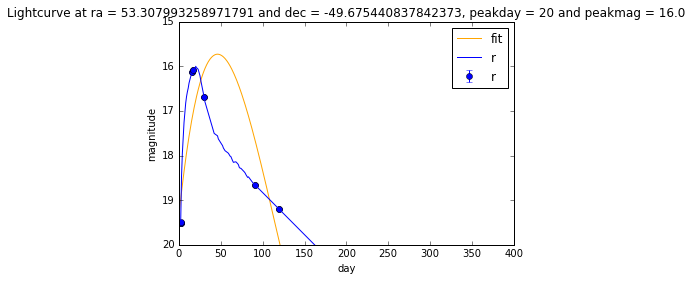

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
14.091929      i 16.3500275817      23.528963  0.00029186374336
19.896267      i  16.103355153      23.330298 0.000279239709051
 19.91221      i 16.1024732584      23.537614 0.000230514377973
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 4.005337      z 17.9982543168      23.106854 0.00196478232392
 4.017258      z 17.9917233399      23.222483 0.00175570057597
28.093268      z  16.246472524      21.744084 0.00137312389647
28.102726      z  16.246879218      21.764722 0.00134777439948
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r     20.011232      24.141548  0.00483757727696
 2.044932      r  20.01401

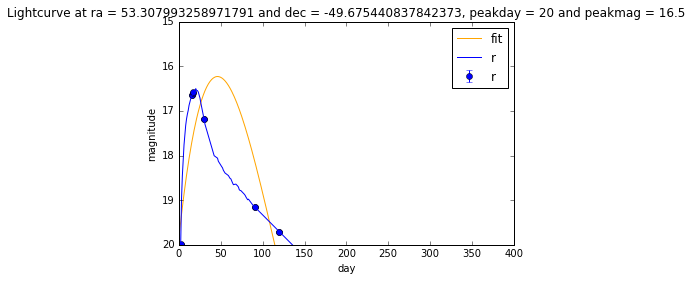

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
14.091929      i 16.8500275817      23.528963 0.000462572859978
19.896267      i  16.603355153      23.330298  0.00044256511394
 19.91221      i 16.6024732584      23.537614 0.000365340668413
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 4.005337      z 18.4982543168      23.106854 0.00311397012985
 4.017258      z 18.4917233399      23.222483 0.00278259789086
28.093268      z  16.746472524      21.744084 0.00217625471591
28.102726      z  16.746879218      21.764722 0.00213607847071
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r     20.511232      24.141548  0.00766704329425
 2.044932      r  20.51401

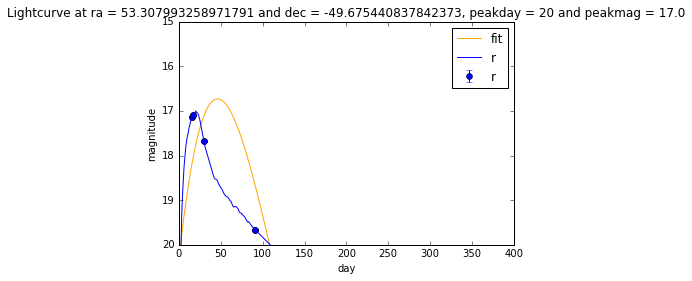

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
14.091929      i 17.3500275817      23.528963 0.000733128576796
19.896267      i  17.103355153      23.330298 0.000701418436304
 19.91221      i 17.1024732584      23.537614 0.000579025938297
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 4.005337      z 18.9982543168      23.106854 0.00493531006033
 4.017258      z 18.9917233399      23.222483 0.00441012045457
28.093268      z  17.246472524      21.744084 0.00344913128431
28.102726      z  17.246879218      21.764722 0.00338545622679
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 2.019037      r     21.011232      24.141548   0.0121514447234
 2.044932      r  21.01401

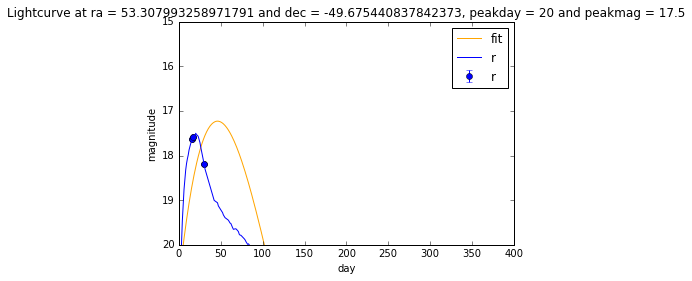

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
14.091929      i 17.8500275817      23.528963  0.00116193049056
19.896267      i  17.603355153      23.330298  0.00111167330477
 19.91221      i 17.6024732584      23.537614 0.000917694267866
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 4.005337      z 19.4982543168      23.106854  0.0078219393173
 4.017258      z 19.4917233399      23.222483 0.00698956988639
28.093268      z  17.746472524      21.744084 0.00546650469241
28.102726      z  17.746879218      21.764722 0.00536558652721
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
15.969716      r 17.2705536856      24.078713 0.000410667741602
15.979383      r 17.268381

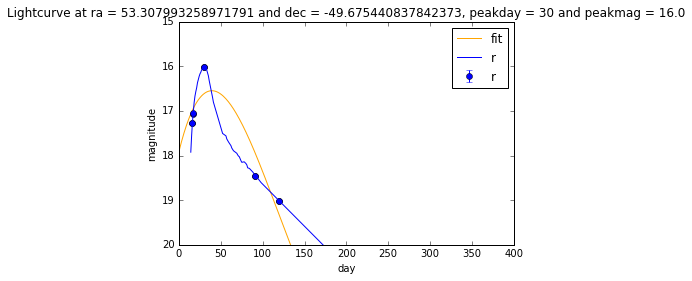

   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
14.091929      i 18.0750828384      23.528963  0.00142955954956
19.896267      i     16.695363      23.330298 0.000481704069865
 19.91221      i 16.6971344444      23.537614 0.000398623128622
   day    filter  magnitude   fiveSigmaDepth      error      
--------- ------ ------------ -------------- ----------------
28.093268      z 16.094778168      21.744084 0.00119407603681
28.102726      z 16.094078276      21.764722 0.00117083804543
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
15.969716      r 17.7705536856      24.078713 0.000650864508028
15.979383      r 17.7683816403      23.998156  0.00069959157664
16.904195      r 17.5605887801      24.226121 0.000468318622523
16.927367      r 17.55538234

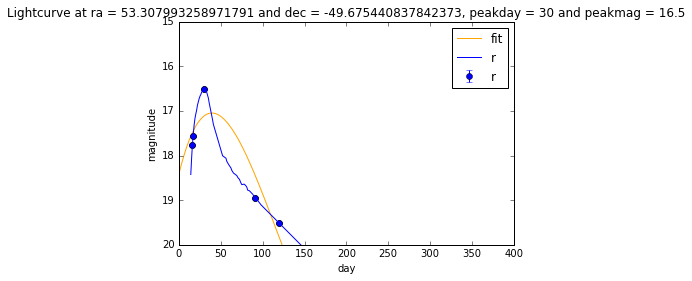

   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
14.091929      i 18.5750828384      23.528963 0.00226569919832
19.896267      i     17.195363      23.330298 0.00076344950111
 19.91221      i 17.1971344444      23.537614 0.00063177508291
   day    filter  magnitude   fiveSigmaDepth      error      
--------- ------ ------------ -------------- ----------------
28.093268      z 16.594778168      21.744084 0.00189248298202
28.102726      z 16.594078276      21.764722 0.00185565324767
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
15.969716      r 18.2705536856      24.078713  0.00103155072799
15.979383      r 18.2683816403      23.998156  0.00110877792732
16.904195      r 18.0605887801      24.226121 0.000742234996739
16.927367      r 18.0553823423   

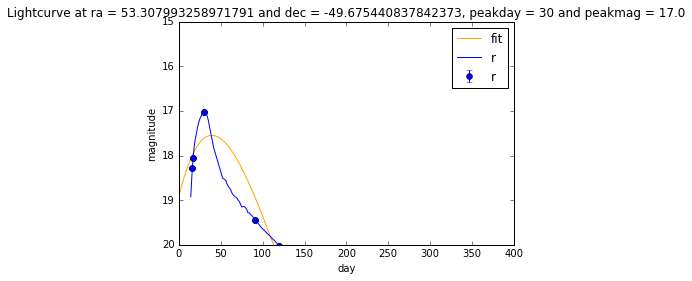

   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
14.091929      i 19.0750828384      23.528963 0.00359089123558
19.896267      i     17.695363      23.330298  0.0012099859171
 19.91221      i 17.6971344444      23.537614 0.00100129602807
   day    filter  magnitude   fiveSigmaDepth      error      
--------- ------ ------------ -------------- ----------------
28.093268      z 17.094778168      21.744084 0.00299938339505
28.102726      z 17.094078276      21.764722 0.00294101219981
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
15.969716      r 18.7705536856      24.078713  0.00163489772647
15.979383      r 18.7683816403      23.998156  0.00175729458896
16.904195      r 18.5605887801      24.226121  0.00117636319354
16.927367      r 18.5553823423   

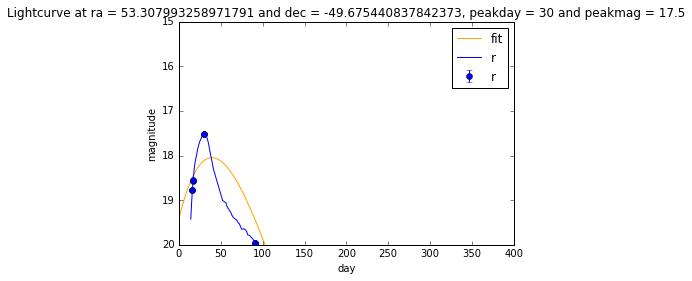

   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
14.091929      i 19.5750828384      23.528963 0.00569117907414
19.896267      i     18.195363      23.330298 0.00191769844298
 19.91221      i 18.1971344444      23.537614 0.00158694725853
   day    filter  magnitude   fiveSigmaDepth      error      
--------- ------ ------------ -------------- ----------------
28.093268      z 17.594778168      21.744084  0.0047537023244
28.102726      z 17.594078276      21.764722 0.00466119021442
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.918077      r 16.5668812332      24.083722 0.000213805074627
29.930788      r 16.5678032746      24.236233 0.000185944109726
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    fil

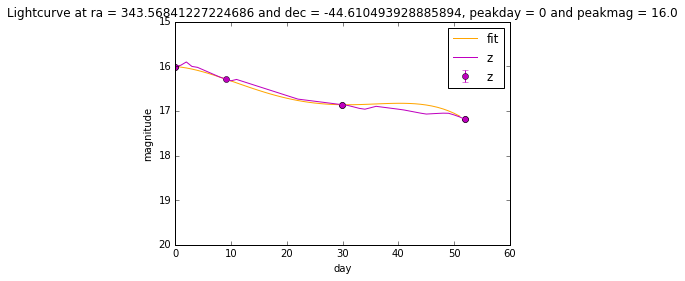

  day    filter   magnitude   fiveSigmaDepth       error      
-------- ------ ------------- -------------- -----------------
4.034544      g 17.2991017232      24.579593 0.000265801731007
4.057829      g 17.3018705049      24.775919 0.000222400068967
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
      day       filter   magnitude   fiveSigmaDepth      error      
--------------- ------ ------------- -------------- ----------------
            0.0      z 16.5069615385      22.331496 0.00101610954504
0.0248090000023      z 16.5062458942      22.307043 0.00103856928225
       9.145363      z  16.791712609      21.748718 0.00225918689029
      29.950503      z 17.3619087153      22.401115 0.00209445870335
      29.967985      z 17.3621851183      22.417744 0.00206314980396


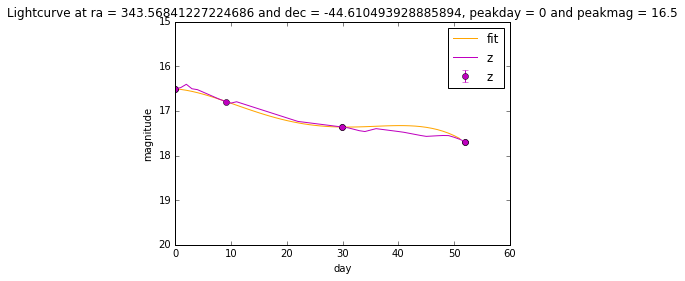

  day    filter   magnitude   fiveSigmaDepth       error      
-------- ------ ------------- -------------- -----------------
4.034544      g 17.7991017232      24.579593 0.000421267354018
4.057829      g 17.8018705049      24.775919 0.000352480355309
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
      day       filter   magnitude   fiveSigmaDepth      error      
--------------- ------ ------------- -------------- ----------------
            0.0      z 17.0069615385      22.331496 0.00161042510073
0.0248090000023      z 17.0062458942      22.307043 0.00164602138534
       9.145363      z  17.291712609      21.748718 0.00358056992293
      29.950503      z 17.8619087153      22.401115 0.00331949334083
      29.967985      z 17.8621851183      22.417744 0.00326987207932


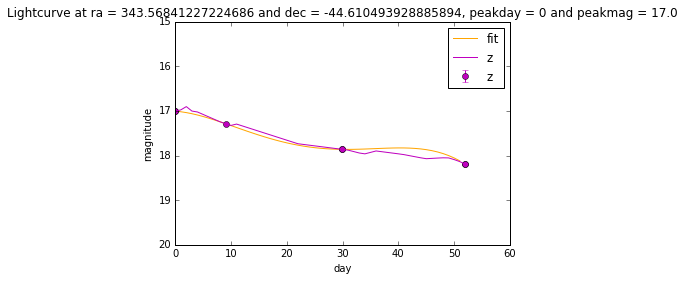

  day    filter   magnitude   fiveSigmaDepth       error      
-------- ------ ------------- -------------- -----------------
4.034544      g 18.2991017232      24.579593 0.000667663761589
4.057829      g 18.3018705049      24.775919 0.000558643715605
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
      day       filter   magnitude   fiveSigmaDepth      error      
--------------- ------ ------------- -------------- ----------------
            0.0      z 17.5069615385      22.331496 0.00255235177912
0.0248090000023      z 17.5062458942      22.307043 0.00260876808828
       9.145363      z  17.791712609      21.748718 0.00567482089598
      29.950503      z 18.3619087153      22.401115 0.00526104239831
      29.967985      z 18.3621851183      22.417744 0.00518239799874


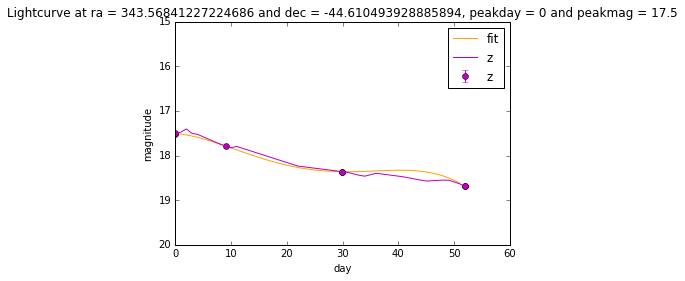

  day    filter   magnitude   fiveSigmaDepth       error      
-------- ------ ------------- -------------- -----------------
4.034544      g  16.522381996      24.579593 0.000129978019131
4.057829      g 16.5224760768      24.775919 0.000108486861751
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
      day       filter   magnitude   fiveSigmaDepth      error      
--------------- ------ ------------- -------------- ----------------
            0.0      z     16.630983      22.331496 0.00113906659497
0.0248090000023      z  16.629420033      22.307043 0.00116333589575
       9.145363      z 16.0316145288      21.748718 0.00112179352047
      29.950503      z 16.6543549839      22.401115 0.00109156677755
      29.967985      z 16.6550558532      22.417744 0.00107567000102


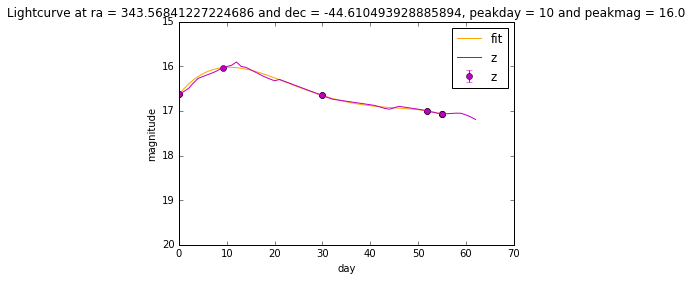

  day    filter   magnitude   fiveSigmaDepth      error      
-------- ------ ------------- -------------- ----------------
4.034544      g  17.022381996      24.579593 0.00020600127769
4.057829      g 17.0224760768      24.775919 0.00017194008866
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
      day       filter   magnitude   fiveSigmaDepth      error      
--------------- ------ ------------- -------------- ----------------
            0.0      z     17.130983      22.331496 0.00180529889213
0.0248090000023      z  17.129420033      22.307043 0.00184376314172
       9.145363      z 16.5316145288      21.748718 0.00177792291393
      29.950503      z 17.1543549839      22.401115 0.00173001675485
      29.967985      z 17.1550558532      22.417744 0.00170482206195


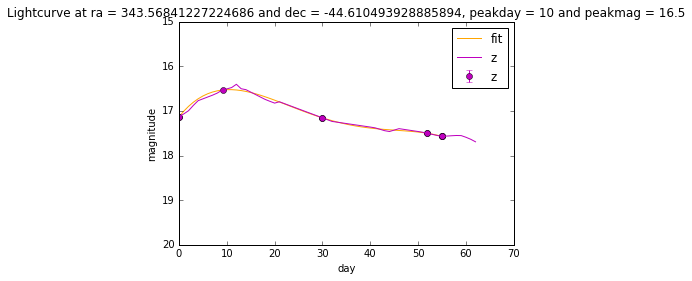

  day    filter   magnitude   fiveSigmaDepth       error      
-------- ------ ------------- -------------- -----------------
4.034544      g  17.522381996      24.579593  0.00032649002265
4.057829      g 17.5224760768      24.775919 0.000272506676028
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
      day       filter   magnitude   fiveSigmaDepth      error      
--------------- ------ ------------- -------------- ----------------
            0.0      z     17.630983      22.331496  0.0028612059245
0.0248090000023      z  17.629420033      22.307043 0.00292216765182
       9.145363      z 17.0316145288      21.748718 0.00281781792302
      29.950503      z 17.6543549839      22.401115 0.00274189177761
      29.967985      z 17.6550558532      22.417744 0.00270196088035


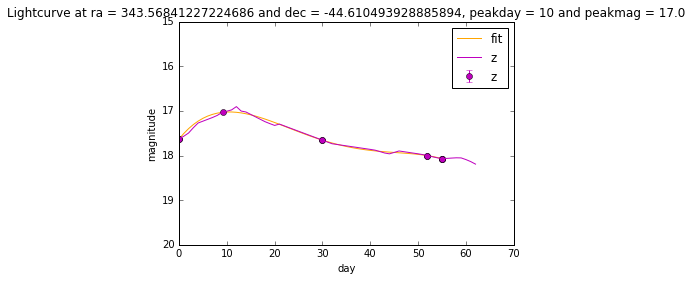

  day    filter   magnitude   fiveSigmaDepth       error      
-------- ------ ------------- -------------- -----------------
4.034544      g  18.022381996      24.579593 0.000517451814304
4.057829      g 18.0224760768      24.775919 0.000431893975737
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
      day       filter   magnitude   fiveSigmaDepth      error      
--------------- ------ ------------- -------------- ----------------
            0.0      z     18.130983      22.331496 0.00453470579197
0.0248090000023      z  18.129420033      22.307043 0.00463132361859
       9.145363      z 17.5316145288      21.748718 0.00446594044378
      29.950503      z 18.1543549839      22.401115 0.00434560561279
      29.967985      z 18.1550558532      22.417744 0.00428231940556


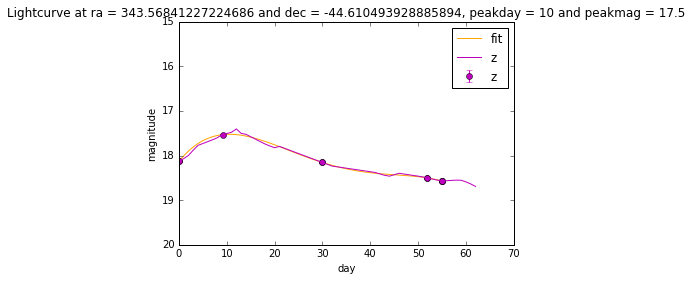

  day    filter   magnitude   fiveSigmaDepth       error      
-------- ------ ------------- -------------- -----------------
4.034544      g  18.397078613      24.579593 0.000730715905663
4.057829      g 18.3911672508      24.775919 0.000606531856446
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 9.145363      z  16.763432112      21.748718  0.00220110094594
29.950503      z  16.326333629      22.401115 0.000806940972257
29.967985      z 16.3269377865      22.417744 0.000795118448622
  day    filter   magnitude   fiveSigmaDepth       error      
-------- ------ ------------- -------------- -----------------
4.034544      g  18.897078613      24.579593  0.00115810666451
4.057829      g 18.8911672508      24.775919 0.000961288210292
day filt

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
      day       filter   magnitude   fiveSigmaDepth       error      
--------------- ------ ------------- -------------- -----------------
            0.0      i 17.1073333333      23.776605 0.000466708433757
0.0203519999995      i  17.107798128      23.765399 0.000471752235496
0.0308359999981      i  17.107682804      23.832552 0.000443411178147
0.0563729999994      i  17.107401897      23.900226 0.000416509272639
     day       filter   magnitude   fiveSigmaDepth      error      
-------------- ------ ------------- -------------- ----------------
0.105422000001      z 17.0039205192      21.833013  0.0025416592343
     26.095396      z 17.8009566984      22.592281 0.00263162858429
     26.111753      z 17.8012153143      21.735905 0.00579266537544
day filter magnitude fiveSigmaDepth error
--- ------ --------- ---------

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth      error     
--------- ------ ------------- -------------- ---------------
26.095396      z 17.1856485177      22.592281 0.0014931427254
26.111753      z 17.1849784521      21.735905 0.0032838529136
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
26.095396      z 17.6856485177      22.592281 0.00236647174087
26.111753      z 17.6849784521      21.735905 0.00520455612

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------

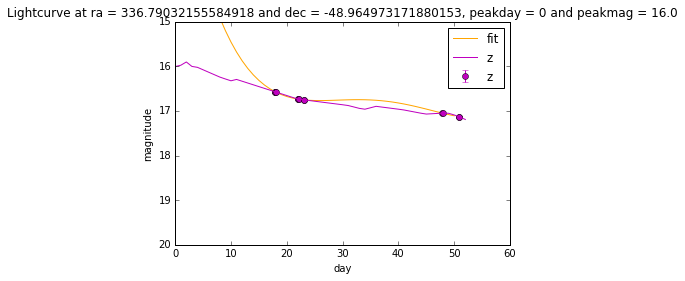

      day       filter  magnitude   fiveSigmaDepth       error      
--------------- ------ ------------ -------------- -----------------
            0.0      g    17.006268      24.043047 0.000332692274095
0.0231219999987      g 17.007817174      24.391202 0.000241768872551
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
29.944034      r 18.2171657015      23.995433 0.00106034549662
29.964022      r 18.2180606866      24.114516 0.00095098176677
     day       filter  magnitude   fiveSigmaDepth       error      
-------------- ------ ------------ -------------- -----------------
0.963675999999      i 16.597421564      23.506747 0.000374131384629
0.988495999998      i 16.597148544      23.509901 0.000372952337307
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z 17.0723080164      22.272694  0.0018055100999
17.916101  

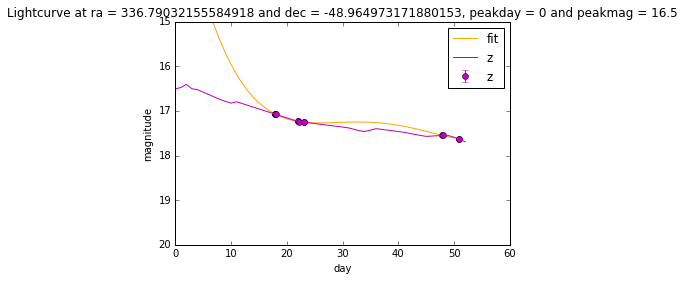

      day       filter  magnitude   fiveSigmaDepth       error      
--------------- ------ ------------ -------------- -----------------
            0.0      g    17.506268      24.043047 0.000527281720398
0.0231219999987      g 17.507817174      24.391202 0.000383177840255
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
29.944034      r 18.7171657015      23.995433 0.00168053435925
29.964022      r 18.7180606866      24.114516 0.00150720452831
     day       filter  magnitude   fiveSigmaDepth       error      
-------------- ------ ------------ -------------- -----------------
0.963675999999      i 17.097421564      23.506747 0.000592958284585
0.988495999998      i 17.097148544      23.509901  0.00059108962051
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z 17.5723080164      22.272694 0.00286154066624
17.916101  

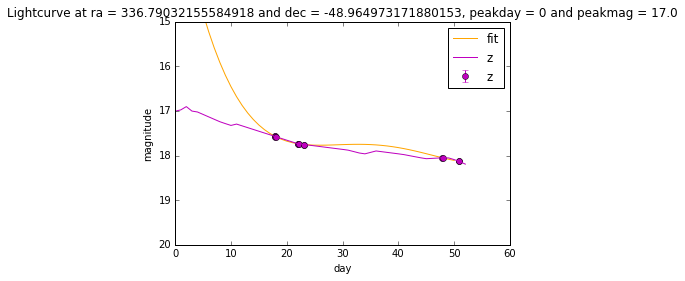

      day       filter  magnitude   fiveSigmaDepth       error      
--------------- ------ ------------ -------------- -----------------
            0.0      g    18.006268      24.043047 0.000835685209168
0.0231219999987      g 18.007817174      24.391202 0.000607295950523
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
29.944034      r 19.2171657015      23.995433 0.00266346746567
29.964022      r 19.2180606866      24.114516 0.00238875819656
     day       filter  magnitude   fiveSigmaDepth       error      
-------------- ------ ------------ -------------- -----------------
0.963675999999      i 17.597421564      23.506747 0.000939775548652
0.988495999998      i 17.597148544      23.509901  0.00093681391568
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z 18.0723080164      22.272694 0.00453523632188
17.916101  

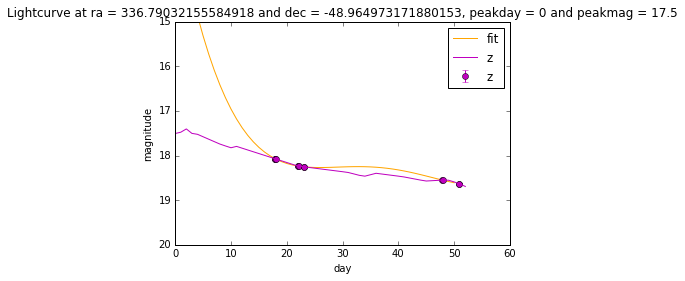

      day       filter   magnitude   fiveSigmaDepth       error      
--------------- ------ ------------- -------------- -----------------
            0.0      g 16.8616969697      24.043047 0.000291215377191
0.0231219999987      g 16.8581936364      24.391202 0.000210644910405
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 17.3726318853      23.995433 0.000487117654324
29.964022      r 17.3739203198      24.114516 0.000437034823581
     day       filter   magnitude   fiveSigmaDepth       error      
-------------- ------ ------------- -------------- -----------------
0.963675999999      i 16.6218528367      23.506747 0.000382645535277
0.988495999998      i 16.6194468163      23.509901 0.000380691028474
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 17.90398      z   16.23761991      22.272694 0.000836998499

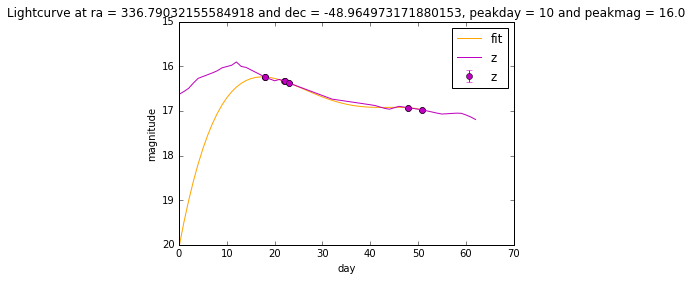

      day       filter   magnitude   fiveSigmaDepth       error      
--------------- ------ ------------- -------------- -----------------
            0.0      g 17.3616969697      24.043047  0.00046154526885
0.0231219999987      g 17.3581936364      24.391202 0.000333849684528
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 17.8726318853      23.995433 0.000772029454266
29.964022      r 17.8739203198      24.114516 0.000692653516762
     day       filter   magnitude   fiveSigmaDepth       error      
-------------- ------ ------------- -------------- -----------------
0.963675999999      i 17.1218528367      23.506747 0.000606452303986
0.988495999998      i 17.1194468163      23.509901 0.000603354619459
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z   16.73761991      22.272694  0.0013265532246

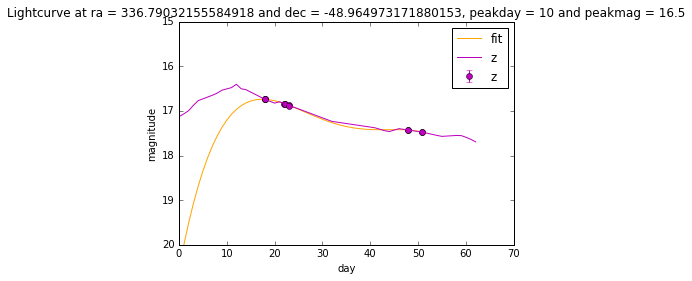

      day       filter   magnitude   fiveSigmaDepth       error      
--------------- ------ ------------- -------------- -----------------
            0.0      g 17.8616969697      24.043047 0.000731499954613
0.0231219999987      g 17.8581936364      24.391202 0.000529116092313
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
29.944034      r 18.3726318853      23.995433 0.00122358422645
29.964022      r 18.3739203198      24.114516 0.00109778184345
     day       filter   magnitude   fiveSigmaDepth       error      
-------------- ------ ------------- -------------- -----------------
0.963675999999      i 17.6218528367      23.506747 0.000961162128141
0.988495999998      i 17.6194468163      23.509901 0.000956252629021
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z   17.23761991      22.272694  0.0021024451751
17.

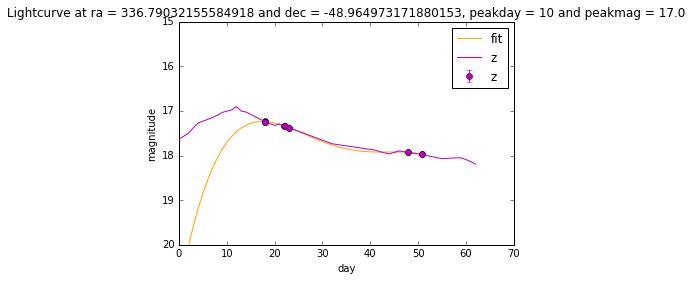

      day       filter   magnitude   fiveSigmaDepth       error      
--------------- ------ ------------- -------------- -----------------
            0.0      g 18.3616969697      24.043047  0.00115934929835
0.0231219999987      g 18.3581936364      24.391202 0.000838592492729
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
29.944034      r 18.8726318853      23.995433  0.0019392503109
29.964022      r 18.8739203198      24.114516 0.00173986697049
     day       filter   magnitude   fiveSigmaDepth      error      
-------------- ------ ------------- -------------- ----------------
0.963675999999      i 18.1218528367      23.506747 0.00152333931374
0.988495999998      i 18.1194468163      23.509901 0.00151555828201
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z   17.73761991      22.272694 0.00333215104554
17.9161

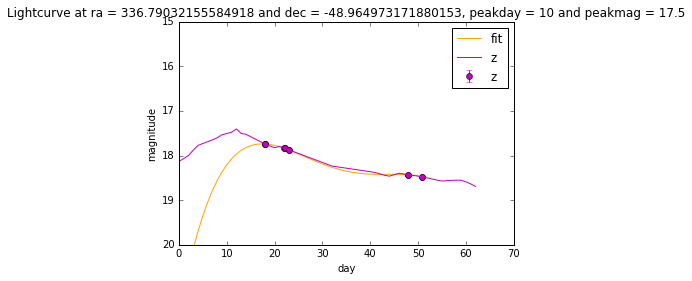

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 16.6867753333      23.995433 0.000258994921897
29.964022      r 16.6895333846      24.114516 0.000232681186379
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 17.90398      z   16.10878548      22.272694 0.000743345826848
17.916101      z  16.107888526      22.343176 0.000696048218153
17.973609      z  16.103632934      22.455141 0.000625390225582
17.990107      z  16.102412082      22.340277 0.000694397819512
 22.06019      z 15.9141224632      21.824011 0.000939288274558
22.079581      z 15.9176156949      21.796148 0.000966810578321
22.152452      z 15.9307431912      22.123029 0.000724169104001


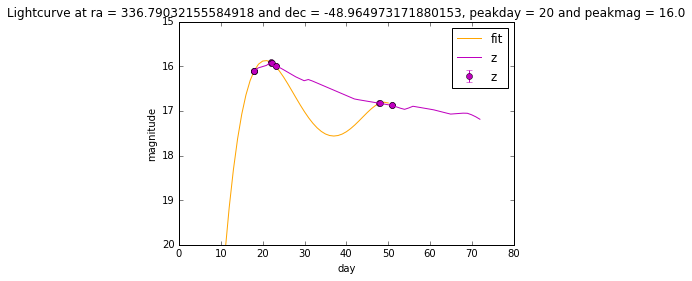

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 17.1867753333      23.995433 0.000410479288596
29.964022      r 17.1895333846      24.114516 0.000368774828305
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
 17.90398      z   16.60878548      22.272694  0.00117812374062
17.916101      z  16.607888526      22.343176  0.00110316208258
17.973609      z  16.603632934      22.455141 0.000991176711156
17.990107      z  16.602412082      22.340277    0.001100546377
 22.06019      z 16.4141224632      21.824011  0.00148867159211
22.079581      z 16.4176156949      21.796148  0.00153229150398
22.152452      z 16.4307431912      22.123029  0.00114773068312


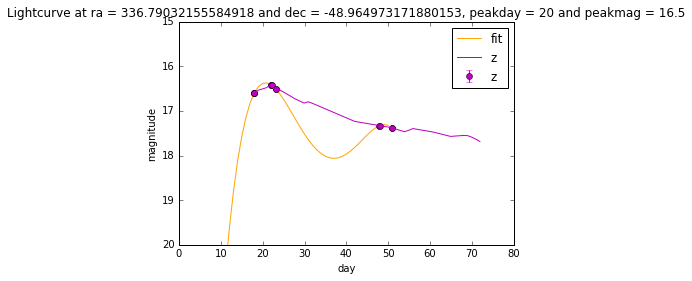

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 17.6867753333      23.995433 0.000650565830142
29.964022      r 17.6895333846      24.114516 0.000584468714932
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z   17.10878548      22.272694 0.00186720029638
17.916101      z  17.107888526      22.343176 0.00174839407485
17.973609      z  17.103632934      22.455141 0.00157090922204
17.990107      z  17.102412082      22.340277  0.0017442484609
 22.06019      z 16.9141224632      21.824011 0.00235938547214
22.079581      z 16.9176156949      21.796148 0.00242851837352
22.152452      z 16.9307431912      22.123029 0.00181903054646
23.082621

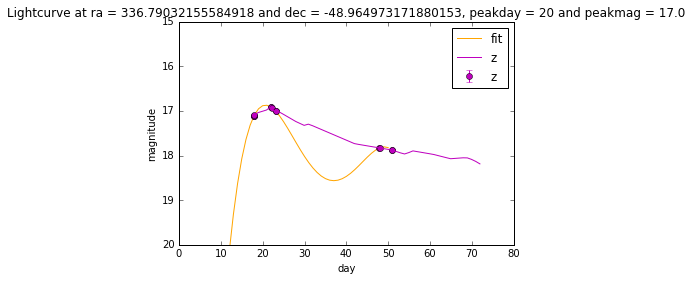

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 18.1867753333      23.995433  0.00103107735544
29.964022      r 18.1895333846      24.114516 0.000926320487503
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z   17.60878548      22.272694 0.00295931303869
17.916101      z  17.607888526      22.343176 0.00277101786698
17.973609      z  17.603632934      22.455141 0.00248972333198
17.990107      z  17.602412082      22.340277 0.00276444751164
 22.06019      z 17.4141224632      21.824011 0.00373937397318
22.079581      z 17.4176156949      21.796148 0.00384894223797
22.152452      z 17.4307431912      22.123029 0.00288296912996
23.082621

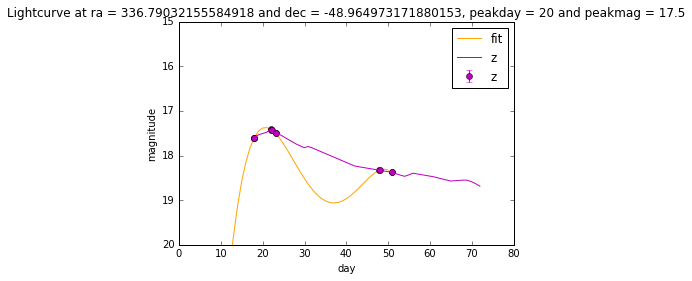

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 16.0192824573      23.995433 0.000140053542582
29.964022      r  16.018454654      24.114516 0.000125409309673
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z   16.98191552      22.272694 0.00166128033267
17.916101      z  16.979782224      22.343176 0.00155380603971
17.973609      z  16.969660816      22.455141 0.00138855229963
17.990107      z  16.966757168      22.340277 0.00153938192482
 22.06019      z  16.489025985      21.824011 0.00159499861264
22.079581      z 16.4867281515      21.796148 0.00163300072006
22.152452      z  16.478092938      22.123029 0.00119889152685
23.082621

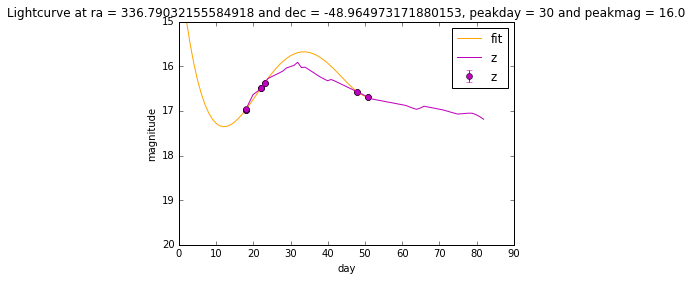

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 16.5192824573      23.995433 0.000221969906218
29.964022      r  16.518454654      24.114516 0.000198760361172
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z   17.48191552      22.272694 0.00263295189002
17.916101      z  17.479782224      22.343176 0.00246261661474
17.973609      z  17.469660816      22.455141 0.00220070708706
17.990107      z  17.466757168      22.340277 0.00243975593325
 22.06019      z  16.989025985      21.824011 0.00252790244316
22.079581      z 16.9867281515      21.796148 0.00258813172451
22.152452      z  16.978092938      22.123029  0.0019001150194
23.082621

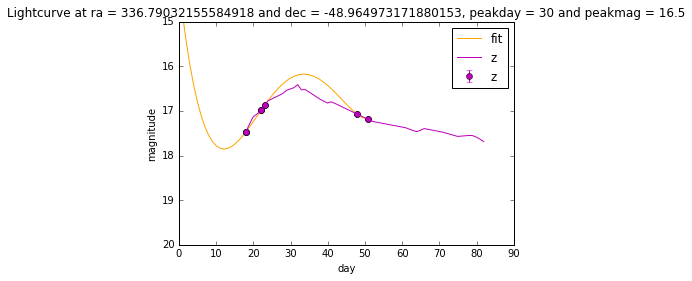

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 17.0192824573      23.995433 0.000351798593296
29.964022      r  17.018454654      24.114516 0.000315013943353
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z   17.98191552      22.272694 0.00417294752656
17.916101      z  17.979782224      22.343176 0.00390298430834
17.973609      z  17.969660816      22.455141 0.00348788568089
17.990107      z  17.966757168      22.340277 0.00386675256987
 22.06019      z  17.489025985      21.824011 0.00400645537338
22.079581      z 17.4867281515      21.796148 0.00410191235137
22.152452      z  17.478092938      22.123029 0.00301147935914
23.082621

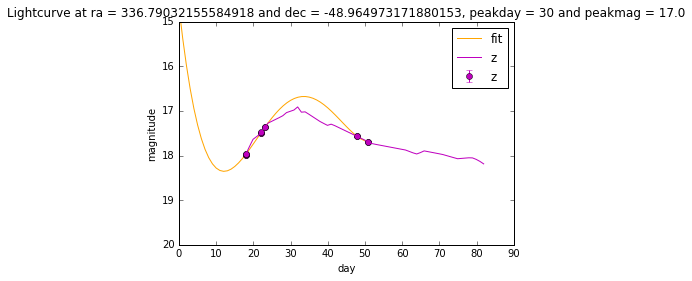

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 17.5192824573      23.995433 0.000557563195633
29.964022      r  17.518454654      24.114516 0.000499263454351
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth      error      
--------- ------ ------------- -------------- ----------------
 17.90398      z   18.48191552      22.272694 0.00661367612735
17.916101      z  18.479782224      22.343176 0.00618581326058
17.973609      z  18.469660816      22.455141 0.00552792627172
17.990107      z  18.466757168      22.340277 0.00612838982492
 22.06019      z  17.989025985      21.824011 0.00634980384716
22.079581      z 17.9867281515      21.796148 0.00650109296176
22.152452      z  17.978092938      22.123029 0.00477287313554
23.082621

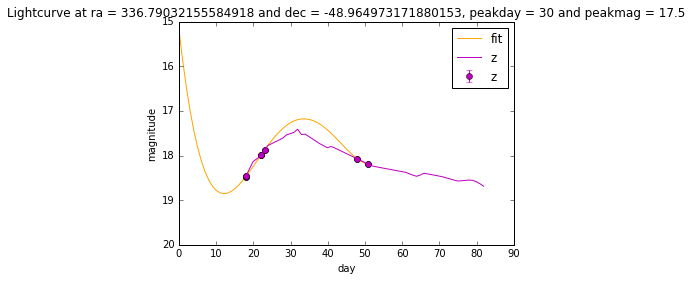

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 16.5687641244      23.995433 0.000232320088991
29.964022      r 16.5702140311      24.114516 0.000208465181459
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter magnitude fiveSigmaDepth      error      
--------- ------ --------- -------------- ----------------
 22.06019      z     18.01      21.824011  0.0064736604374
22.079581      z     18.01      21.796148 0.00664194256257
22.152452      z     18.01      22.123029 0.00491521722123
23.082621      z     18.01      21.606314 0.00791095138456
23.096271      z     18.01      21.661056 0.00752197551903


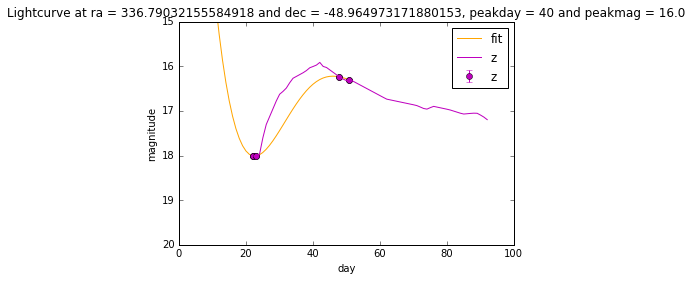

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 17.0687641244      23.995433 0.000368202527513
29.964022      r 17.0702140311      24.114516 0.000330395046959
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter magnitude fiveSigmaDepth      error     
--------- ------ --------- -------------- ---------------
 22.06019      z     18.51      21.824011 0.0102600603575
22.079581      z     18.51      21.796148 0.0105267695521
22.152452      z     18.51      22.123029 0.0077900943134
23.082621      z     18.51      21.606314 0.0125380129953
23.096271      z     18.51      21.661056  0.011921527794


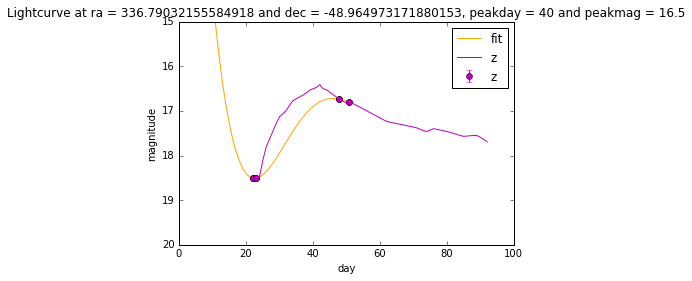

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 17.5687641244      23.995433 0.000583561679303
29.964022      r 17.5702140311      24.114516 0.000523640860748
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter magnitude fiveSigmaDepth      error     
--------- ------ --------- -------------- ---------------
 22.06019      z     19.01      21.824011 0.0162610998149
22.079581      z     19.01      21.796148 0.0166838054018
22.152452      z     19.01      22.123029 0.0123464674459
23.082621      z     19.01      21.606314 0.0198714114432
23.096271      z     19.01      21.661056 0.0188943482444


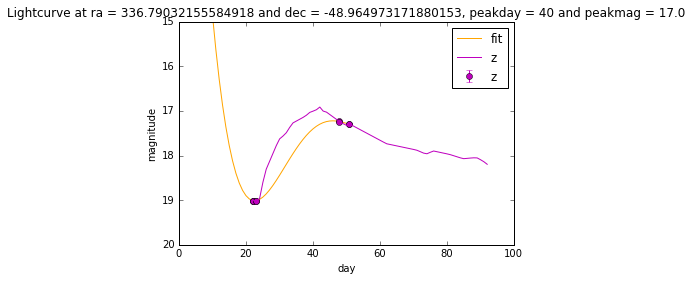

day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter   magnitude   fiveSigmaDepth       error      
--------- ------ ------------- -------------- -----------------
29.944034      r 18.0687641244      23.995433 0.000924882932908
29.964022      r 18.0702140311      24.114516 0.000829914835494
day filter magnitude fiveSigmaDepth error
--- ------ --------- -------------- -----
   day    filter magnitude fiveSigmaDepth      error     
--------- ------ --------- -------------- ---------------
 22.06019      z     19.51      21.824011 0.0257721063986
22.079581      z     19.51      21.796148 0.0264420496056
22.152452      z     19.51      22.123029  0.019567832206
23.082621      z     19.51      21.606314 0.0314940647209
23.096271      z     19.51      21.661056 0.0299455239085


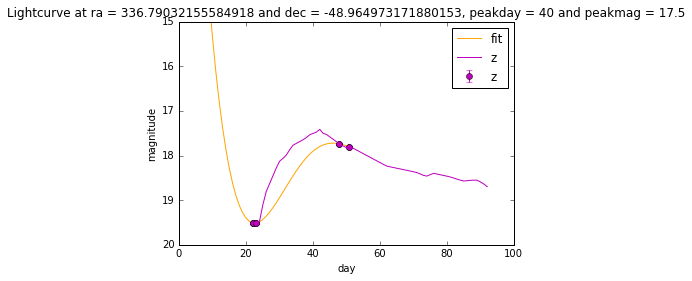

In [38]:
read_curve = ReadCurve(jsonLC)
lc_table = read_curve.read_lightcurve(jsonLC)
peakTable = peak_brightness(lc_table)
survey = createdict_for_mjd_filter_depth(bundle)
bdict = {}
for coord in range(len(bundle.metricValues)):
    enough = 0.
    not_enough = 0.
    opsim = list(survey)
    opsim = opsim[coord]
    opsim = opsim['fieldRA', 'fieldDec', 'day', 'filter', 'fiveSigmaDepth']
    opsim = opsim[opsim['filter'] != 'u']
    opsim = opsim[opsim['filter'] != 'y']
    
    ra = np.degrees(round(opsim['fieldRA'][0], 4))
    dec = np.degrees(round(opsim['fieldDec'][0], 4))
    
    opsim['day'] = (opsim['day'] - opsim['day'].min())
    opsim.sort('day')
    
    for peakday in location_of_peak:
        for peakmag in height_of_peak:
            adjusted_lc_table = adjust_peak(lc_table, peakTable, peakday, peakmag)
            new_opsim = opsim.copy()
            new_opsim = new_opsim[new_opsim['day']< adjusted_lc_table['day'].max()]
            new_opsim = new_opsim[new_opsim['day']> adjusted_lc_table['day'].min()]
            lightcurve = interpolate_light_curve(adjusted_lc_table, new_opsim)
            opsim1 = resample_light_curve(lightcurve, new_opsim)
            opsim1 = calculate_error(opsim1)
            
            times = np.arange(new_opsim['day'].min(), new_opsim['day'].max(), 1)
            lightcurve2 = interpolate_original(adjusted_lc_table, times)
            opsim2 = change_lightcurve_to_table(lightcurve2)
            
            final_opsim = opsim1.copy()
            final_opsim = final_opsim[final_opsim['day'] <= 30]
            for f in filterNames:
                fMatch = np.where(final_opsim['filter'] == f)
                fMatch2 = np.where(opsim1['filter'] == f)
                fMatch3 = np.where(opsim2['filter'] == f)
                opsim_fmatch = final_opsim[fMatch]
                opsim_fmatch2 = opsim1[fMatch2]
                opsim_fmatch3 = opsim2[fMatch3]
                if len(opsim_fmatch) >= 5:
                    #print('enough points for filter = %s, ra = %r, dec = %r' %(f, ra, dec))
                    #plot_light_curve(opsim_fmatch2, f, ra, dec, peakday, peakmag)
                    create_curve2(opsim_fmatch, opsim_fmatch3, f, adjusted_lc_table, ra, dec, peakday, peakmag)
                    #resampled_peak_magnitude(opsim_fmatch2, f, adjusted_lc_table, ra, dec)
                    #resampled_peak_day(opsim_fmatch2, f, adjusted_lc_table, ra, dec)
                    enough += 1
                else:
                    not_enough += 1
    #percent_with_atleast_4 = enough/(enough + not_enough)*100
    #bdict[ra,dec] = percent_with_atleast_4
#print bdict
#print('enough = %d' %(enough))
#print('not enough = %d' %(not_enough))